In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Check for GPU
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-d05bd528-fe6e-4e94-4f00-687b6fd004a2)


In [ ]:
!pip install python-docx

     |████████████████████████████████| 5.6MB 5.8MB/s 
  Created wheel for python-docx: filename=python_docx-0.8.11-cp37-none-any.whl size=184508 sha256=aa96fcb8767568ac408c1be496f333c0c78a63114eb858fecb081f71891e65af
  Stored in directory: /root/.cache/pip/wheels/a6/90/f1/a7cb70b38633ae04e7fb963b1c70f63fd6fc01c075b8230adc
Successfully built python-docx


In [ ]:
# import required Libraries
import warnings
import os
import pandas as pd 
import numpy as np

from google.colab import files
import time

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import pyplot
import seaborn as sns
import tensorflow 
print(tensorflow.__version__)
# suppress display of warnings
warnings.filterwarnings('ignore')
# display all dataframe columns
pd.options.display.max_columns = None

# to set the limit to 3 decimals
pd.options.display.float_format = '{:.7f}'.format

# display all dataframe rows
pd.options.display.max_rows = None

2.5.0


In [ ]:
# Write a Function to evaluate: accuracy, precision, recall, f1-score
# and return the values as a dictionary
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.
  and returns as a dictionary
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

## Download text dataset

In [ ]:
#Load scraped and cleaned data in a dataframe
clean_filepath ="/content/drive/MyDrive/AI-ML/Data/Final_Articles_Data_25June.csv"# data
df = pd.read_csv(clean_filepath, engine="python")
#create a new dataset only with required columns
data = df[['Cleaned_Article','Domain']].copy()
data.rename(columns ={'Cleaned_Article' : 'Cleaned_Article_Text'}, inplace = True)

In [ ]:
#check dataframe info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29631 entries, 0 to 29630
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Cleaned_Article_Text  29631 non-null  object
 1   Domain                29631 non-null  object
dtypes: object(2)
memory usage: 463.1+ KB


In [ ]:
#check dataframe head
data.head()

,Cleaned_Article_Text,Domain
0,One of the most common challenges I see client...,Marketing
1,"Lets say that, like me, youve been thinking ab...",Marketing
2,"If youre like most entrepreneurs, you may have...",Marketing
3,I had an interesting project come across my de...,Marketing
4,"In a world where personal touch matters, why a...",Marketing


Shuffle data.

In [ ]:
# Shuffle  dataframe
data_shuffled = data.sample(frac=1, random_state=42) # shuffle with random_state=42 for reproducibility
data_shuffled.head()

,Cleaned_Article_Text,Domain
762,The following excerpt is from Dan S. Kennedys ...,Marketing
26694,"You're reading Entrepreneur Middle East, an in...",Technology
19411,"In the midst of a global health crisis, it can...",Strategy
12865,"Making decisions, even small, seemly harmless ...",Leadership
4702,"JDate, the premier community for Jewish single...",Marketing


### Split data into training and validation sets

In [ ]:
#Train Validation Split
from sklearn.model_selection import train_test_split

# Use train_test_split to split training data into training and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(data_shuffled["Cleaned_Article_Text"],
                                                                            data_shuffled["Domain"],
                                                                            test_size=0.1, # dedicate 10% of samples to validation set
                                                                            random_state=42) # random state for reproducibility

#### Make Neumeric Labels

In [ ]:
# One hot encode labels 
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_labels.to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_labels.to_numpy().reshape(-1, 1))

# Check what training labels look like
train_labels_one_hot

array([[0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [ ]:
# Label Encode the target labels
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels.to_numpy())
val_labels_encoded = label_encoder.transform(val_labels.to_numpy())

# Check what label encoded training labels look like
train_labels_encoded

array([2, 3, 2, ..., 2, 2, 4])

In [ ]:
# Convert  text lines into lists 
train_sentences = train_sentences.tolist()
val_sentences = val_sentences.tolist()
len(train_sentences), len(val_sentences)

(26667, 2964)

In [ ]:
# Get class names and number of classes from LabelEncoder instance 
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5, array(['Finance', 'Leadership', 'Marketing', 'Strategy', 'Technology'],
       dtype=object))

In [ ]:
# Check the lengths of train and validation sets
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(26667, 26667, 2964, 2964)



---



---



---



#MODEL 0 - A simple ML model - Using TF-IDF encoder and MultinomialNB classifier

To start with our experimentation for building a classification model for predicting domain for a new piece or article, we first created a baselime model and then tried multiple experimentation to further improve the model performance. We used the scraped data from internet to train thes experimental models and picked up the best performing one later for prediction on new data.


In [ ]:
#Vectorize using TFIDF vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
X = TfidfVectorizer(train_sentences)

# Import necessary libraries and packages
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
  ("tf-idf", TfidfVectorizer()),
  ("clf", MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X=train_sentences, y=train_labels_encoded)


Pipeline(memory=None,
         steps=[('tf-idf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [ ]:
# Evaluate baseline on validation dataset
model_0.score(X=val_sentences, y=val_labels_encoded)

0.6177462887989204

In [ ]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([1, 1, 2, ..., 1, 2, 0])

In [ ]:
# Calculate baseline results using custome created function
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 61.774628879892035,
 'f1': 0.558137458208498,
 'precision': 0.6972104533250983,
 'recall': 0.6177462887989204}

In [ ]:
#Confusion Metrics and Classification Report
#Classes 'Finance', 'Leadership', 'Marketing', 'Strategy', 'Technology'
from sklearn.metrics import confusion_matrix , classification_report
print(confusion_matrix(val_labels_encoded, baseline_preds))
print(classification_report(val_labels_encoded, baseline_preds))

[[284  66 100   1  20]
 [  3 544  67   0   2]
 [  0  23 686   0  13]
 [  5 267 258   2  10]
 [  5  51 242   0 315]]
              precision    recall  f1-score   support

           0       0.96      0.60      0.74       471
           1       0.57      0.88      0.69       616
           2       0.51      0.95      0.66       722
           3       0.67      0.00      0.01       542
           4       0.88      0.51      0.65       613

    accuracy                           0.62      2964
   macro avg       0.72      0.59      0.55      2964
weighted avg       0.70      0.62      0.56      2964



In [ ]:
#Save the baseline model_0
import pickle
model_0_path = "/content/drive/MyDrive/AI-ML/models/model_0_path/model_0.sav" # this folder has to be manually created as of now
pickle.dump(model_0, open(model_0_path, 'wb'))

##MODEL 0 Results Analysis - 

---



We created a Baseline model using  Scikit-Learn Pipeline with the TF-IDF (term frequency-inverse document frequency) for converting words to numbers and Multinomial Naive Bayes for classification following the guideline on [Scikit-Learn machine learning map](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html) . 

The Baseline model gave 62% accuracy, and F1 score was only 0.56.  The model  failed totally on predicting articles with Domain 'Strategy' and gave only 0.01 F1-score on this classs.

Thus, we next moved to build some Deep Learning based models and try to improve on the performance parameters.


---



---



### Preparing  data for deep sequence models

In [ ]:
# How long is each sentence on average?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len # return average sentence length (in tokens)

797.262046724416

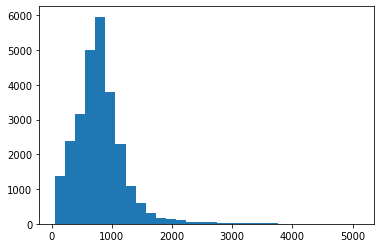

In [ ]:
# What's the distribution look like?
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=30);


In [ ]:
# How long of a sentence covers 95% of the lengths?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

1473

95% of the articles have 1473 words (tokens) or less

In [ ]:
# Maximum sentence length in the training set
max(sent_lens)

5103

 Max Length is 5k+ words

In [ ]:
#Create a Text Vectorizer and fit to training data
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# Setup text vectorization variables
max_vocab_length = 30000 # max number of words to have in our vocabulary
max_length = 500 # max length our sequences

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)
# Fit the text vectorizer to the training text
text_vectorizer.adapt(train_sentences)

In [ ]:
# Choose a random sentence from the training dataset and tokenize it
import random
target_sentence = random.choice(train_sentences)
print(f"Original text:\n{target_sentence}\
      \n\nVectorized version:")
text_vectorizer([target_sentence])

Original text:
If you have recently been directed to work from home, odds are you're going to need to know about Zoom. Zoom is the premier application for remote work meetings and one of the best ways I've personally been able to keep my business running with a remote team. It is easy to use, but there are a few tricks that can make your Zoom experience seamless.Applying the following tips can help you avoid potential disasters when organizing your first online business meeting.Meeting IDAlthough Zoom allows you to schedule meetings, you might find it easier to use a meeting ID instead. This ID can be used repeatedly, eliminating the need to set up a new room for every meeting. Team members can save this code to reference for every planned meeting. You can schedule your meeting on your companys calendar and start the meeting without having to schedule it in Zoom.Related 25 Tech Tools, Tricks and Tips to Get the Most Out of Your ChromebookChatsWhile using Zoom for video or audio meeting

<tf.Tensor: shape=(1, 500), dtype=int64, numpy=
array([[   34,     8,    22,   598,   106,  5354,     3,    63,    29,
          338,  2677,    16,    76,   146,     3,    66,     3,    90,
           39,  2755,  2755,    11,     2,  9550,  1319,    12,   941,
           63,   695,     4,    48,     6,     2,   105,   155,   435,
         1544,   106,   229,     3,   160,    72,    28,   637,    14,
            5,   941,   102,    15,    11,   301,     3,    93,    30,
           73,    16,     5,   190,  3327,     9,    20,    52,    10,
         2755,   175,     1,     2,   448,   422,    20,    85,     8,
          536,   263,  7414,    40,  4576,    10,    98,   134,    28,
            1,     1,  2755,   491,     8,     3,  1142,   695,     8,
          149,   127,    15,   597,     3,    93,     5,   512,  1197,
          274,    21,  1197,    20,    17,   283,  4893,  3953,     2,
           66,     3,   218,    54,     5,    51,   838,    12,   118,
          512,   102,   391, 

In [ ]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5] # most common tokens (notice the [UNK] token for "unknown" words)
bottom_5_words = words_in_vocab[-5:] # least common tokens
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"Top 5 most common words: {top_5_words}") 
print(f"Bottom 5 least common words: {bottom_5_words}")

Number of words in vocab: 30000
Top 5 most common words: ['', '[UNK]', 'the', 'to', 'and']
Bottom 5 least common words: ['crow', 'critiqued', 'criteo', 'crispy', 'covid19s']


In [ ]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'dtype': 'string',
 'max_tokens': 30000,
 'name': 'text_vectorization',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 500,
 'pad_to_max_tokens': False,
 'split': 'whitespace',
 'standardize': 'lower_and_strip_punctuation',
 'trainable': True,
 'vocabulary_size': 30000}

In [ ]:
# Create token embedding layer

from tensorflow.keras import layers
token_embed = layers.Embedding(input_dim=30000, # length of vocabulary
                               output_dim=128,
                               mask_zero=True,
                               name="token_embedding") 

In [ ]:
# Show example embedding
print(f"Sentence before vectorization:\n{target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
If you have recently been directed to work from home, odds are you're going to need to know about Zoom. Zoom is the premier application for remote work meetings and one of the best ways I've personally been able to keep my business running with a remote team. It is easy to use, but there are a few tricks that can make your Zoom experience seamless.Applying the following tips can help you avoid potential disasters when organizing your first online business meeting.Meeting IDAlthough Zoom allows you to schedule meetings, you might find it easier to use a meeting ID instead. This ID can be used repeatedly, eliminating the need to set up a new room for every meeting. Team members can save this code to reference for every planned meeting. You can schedule your meeting on your companys calendar and start the meeting without having to schedule it in Zoom.Related 25 Tech Tools, Tricks and Tips to Get the Most Out of Your ChromebookChatsWhile using Zoom for video 

In [ ]:
 #Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))


train_dataset

<TensorSliceDataset shapes: ((), (5,)), types: (tf.string, tf.float64)>

In [ ]:
# Take the TensorSliceDataset's and turn them into prefetched batches
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

# EXPREMINTES WITH DEEP MODELS

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LSTM, Dropout, Embedding, TimeDistributed, Bidirectional, GRU,Conv1D
from tensorflow.keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate, SpatialDropout1D

#Model 1: Conv1D with token embeddings

In [ ]:
# Create 1D convolutional model to process sequences
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs) # vectorize text inputs
token_embeddings = token_embed(text_vectors) # create embedding
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
#x = layers.GlobalAveragePooling1D()(x) # condense the output 
avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)
x = concatenate([avg_pool, max_pool])
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

# Compile
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Get summary of Conv1D model
model_1.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
text_vectorization (TextVectori (None, 500)          0           input_3[0][0]                    
__________________________________________________________________________________________________
token_embedding (Embedding)     (None, 500, 128)     3840000     text_vectorization[2][0]         
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 500, 64)      41024       token_embedding[2][0]            
____________________________________________________________________________________________

In [ ]:
# create checkpoint
model_1_path = '/content/drive/MyDrive/AI-ML/models/model_1_path'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(model_1_path, save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)
# Fit the model
model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch=int(len(train_dataset)), 
                              epochs=5,
                              validation_data=valid_dataset,
                              validation_steps=int(len(valid_dataset)),
                              callbacks = [model_checkpoint])

Epoch 1/5
834/834 [==============================] - 36s 43ms/step - loss: 0.4997 - accuracy: 0.8364 - val_loss: 1.0634 - val_accuracy: 0.6444

Epoch 00001: val_accuracy improved from -inf to 0.64440, saving model to /content/drive/MyDrive/AI-ML/models/model_1_path
INFO:tensorflow:Assets written to: /content/drive/MyDrive/AI-ML/models/model_1_path/assets
Epoch 2/5
834/834 [==============================] - 36s 44ms/step - loss: 0.2066 - accuracy: 0.9228 - val_loss: 1.2646 - val_accuracy: 0.6400

Epoch 00002: val_accuracy did not improve from 0.64440
Epoch 3/5
834/834 [==============================] - 37s 44ms/step - loss: 0.1640 - accuracy: 0.9355 - val_loss: 1.4197 - val_accuracy: 0.6292

Epoch 00003: val_accuracy did not improve from 0.64440
Epoch 4/5
834/834 [==============================] - 36s 43ms/step - loss: 0.1569 - accuracy: 0.9376 - val_loss: 1.4973 - val_accuracy: 0.6188

Epoch 00004: val_accuracy did not improve from 0.64440
Epoch 5/5
834/834 [===========================

In [ ]:
#ReLoad the best model
model_1 =  tf.keras.models.load_model(model_1_path)

In [ ]:
# Evaluate on whole validation dataset 
model_1.evaluate(valid_dataset) # print loss and accuracy

93/93 [==============================] - 1s 13ms/step - loss: 1.0634 - accuracy: 0.6444


[1.063425898551941, 0.6443994641304016]

In [ ]:
# Make predictions (our model outputs prediction probabilities for each class)
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs

array([[4.5391938e-05, 9.1608143e-01, 5.7843205e-04, 8.2956456e-02,
        3.3816922e-04],
       [9.0072796e-02, 8.4105694e-01, 2.0464862e-04, 6.4880960e-02,
        3.7846081e-03],
       [1.4058815e-02, 2.0013838e-01, 3.3643118e-01, 3.1110850e-01,
        1.3826312e-01],
       ...,
       [1.2583833e-02, 9.8283458e-01, 1.7384255e-04, 3.3820719e-03,
        1.0257420e-03],
       [2.2546561e-02, 5.7590984e-02, 6.3767201e-01, 2.7702323e-01,
        5.1671877e-03],
       [9.9987221e-01, 5.8273214e-05, 4.9984664e-07, 6.6717606e-05,
        2.2577569e-06]], dtype=float32)

In [ ]:
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(2964,), dtype=int64, numpy=array([1, 1, 2, ..., 1, 2, 0])>

In [ ]:
# Calculate model_1 results
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 64.4399460188934,
 'f1': 0.6526836145769144,
 'precision': 0.6693027015275237,
 'recall': 0.6443994601889339}

In [ ]:
from sklearn.metrics import confusion_matrix , classification_report
print(confusion_matrix(val_labels_encoded, model_1_preds))
print(classification_report(val_labels_encoded, model_1_preds))

[[366  21   8  45  31]
 [  8 384  24 185  15]
 [ 16  35 428 172  71]
 [ 35 137  68 270  32]
 [ 21  26  42  62 462]]
              precision    recall  f1-score   support

           0       0.82      0.78      0.80       471
           1       0.64      0.62      0.63       616
           2       0.75      0.59      0.66       722
           3       0.37      0.50      0.42       542
           4       0.76      0.75      0.75       613

    accuracy                           0.64      2964
   macro avg       0.67      0.65      0.65      2964
weighted avg       0.67      0.64      0.65      2964



In [ ]:
# Save Model
#tf.keras.models.save_model(model_1, "/content/drive/MyDrive/AI-ML/models/model_1_path/")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/AI-ML/models/model_1_path/assets


##MODEL 1 SUMMARY -


---

We next created a simple Deep Learning based model that takes the text and labels as input, tokenizes and creates embedding, feeds it thorugh a Conv1D layer. We then  try to reduce dimension by passing it though a Global Average and Global Max Pooling layers and then pass through a fully connected layer with with 5 output units with softmax activation.

This model has 3,881,669 trainable parameters , most of them are form the learnable embedding layer.
This model performs better than the baseline, as through learned embeddings and deep Conv1D layers Accuracy increased to 64% and F1 of 0.65.  The 'Strategy' class now performed better with a 0.42 F1 for this calss.

---






---



---




#Model 2: Feature extraction with pretrained token embeddings

##Transfer Learning for Feature Extraction

---



Since our model_1 had most trainable parameters from the embedding layer, we can try use an existing embedding which is trained and available to us. One such embedding is "Universal Sentence Encoder" (USE)  available on Tensorflow Hub.
The model can take in text, USE layer will tokenize and embed, We will keep the pretrained embeddings frozen (by default trainable=False).
This can be passed through a learnable dense layerto tailor the model outputs to our own data follwed by an output layer with five class nodes and softmax activation.

In Short -

Inputs (string) -> Pretrained embeddings from TensorFlow Hub (Universal Sentence Encoder) -> Layers -> Output (probabilities)

Details of USE - https://tfhub.dev/google/universal-sentence-encoder/4


---
##NOTE:
The Universal Sentence Encoder creates a whole sentence-level embedding with 512 dimensional vector for each sentence. Note that the USE model is a bit large and takes some time to load the first time, howver once loaded it is cashed and runs comapatively faster. There is also a "lite" version of the USE which takes up less space but sacrifices some performance and requires more preprocessing steps. We will use the full version in our experimentation.

Universal Sentence Encoder (USE) takes care of tokenization automatically so no need to tokenize the input.

---



In [ ]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [ ]:
# Test out the embedding on a random sentence
random_training_sentence = random.choice(train_sentences)
print(f"Random training sentence:\n{random_training_sentence}\n")
use_embedded_sentence = tf_hub_embedding_layer([random_training_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]} (truncated output)...\n")
print(f"Length of sentence embedding:\n{len(use_embedded_sentence[0])}")

Random training sentence:
Mobile now influences 19 percent of all retail sales. This creates both a huge risk and once-in-a-lifetime opportunity if marketers can get their mobile strategy right. As we head toward 2015, were seeing more brands than ever adopt a mobile-first strategy. Marketers who want to share screen time with their customers had better make sure their content contains actual substance, or they will verge upon a difficult and dangerous gray area between a great message and spammy one. Get a handle on spam. For mobile marketers, there are three types of spam to avoid. First, because this is actually illegal, you will run into trouble delivering messages to customers who didnt knowingly agree to receive your marketing email. You can provoke rampant frustration by exceeding the number of messages you promised to deliver. This might be be forgivable if the content is relevant, but you can get into serious trouble with the Mobile Marketing Association for doing this. The mo

In [ ]:
# Define feature extractor model using TF Hub layer
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs) # tokenize text and create embedding using TF Hub's USE
x = layers.Dense(128, activation="relu")(pretrained_embedding) # add a fully connected layer on top of the embedding
outputs = layers.Dense(num_classes, activation="softmax")(x) # create the output layer
model_2 = tf.keras.Model(inputs=inputs,
                        outputs=outputs)

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Get a summary of the model
model_2.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None,)]                 0         
_________________________________________________________________
universal_sentence_encoder ( (None, 512)               256797824 
_________________________________________________________________
dense_10 (Dense)             (None, 128)               65664     
_________________________________________________________________
dense_11 (Dense)             (None, 5)                 645       
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
# create checkpoint
model_2_path = '/content/drive/MyDrive/AI-ML/models/model_2_path'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(model_2_path, save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)
# Fit the model
model_2_history = model_2.fit(train_dataset,
                              steps_per_epoch=int(len(train_dataset)), 
                              epochs=5,
                              validation_data=valid_dataset,
                              validation_steps=int(len(valid_dataset)),
                              callbacks = [model_checkpoint])

Epoch 1/5
834/834 [==============================] - 87s 103ms/step - loss: 0.7630 - accuracy: 0.7148 - val_loss: 0.7070 - val_accuracy: 0.7328

Epoch 00001: val_accuracy improved from -inf to 0.73279, saving model to /content/drive/MyDrive/AI-ML/models/model_2_path
INFO:tensorflow:Assets written to: /content/drive/MyDrive/AI-ML/models/model_2_path/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/AI-ML/models/model_2_path/assets


Epoch 2/5
834/834 [==============================] - 87s 104ms/step - loss: 0.6724 - accuracy: 0.7381 - val_loss: 0.6963 - val_accuracy: 0.7335

Epoch 00002: val_accuracy improved from 0.73279 to 0.73347, saving model to /content/drive/MyDrive/AI-ML/models/model_2_path
INFO:tensorflow:Assets written to: /content/drive/MyDrive/AI-ML/models/model_2_path/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/AI-ML/models/model_2_path/assets


Epoch 3/5
834/834 [==============================] - 87s 105ms/step - loss: 0.6561 - accuracy: 0.7444 - val_loss: 0.6895 - val_accuracy: 0.7375

Epoch 00003: val_accuracy improved from 0.73347 to 0.73752, saving model to /content/drive/MyDrive/AI-ML/models/model_2_path
INFO:tensorflow:Assets written to: /content/drive/MyDrive/AI-ML/models/model_2_path/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/AI-ML/models/model_2_path/assets


Epoch 4/5
834/834 [==============================] - 88s 105ms/step - loss: 0.6436 - accuracy: 0.7497 - val_loss: 0.6844 - val_accuracy: 0.7382

Epoch 00004: val_accuracy improved from 0.73752 to 0.73819, saving model to /content/drive/MyDrive/AI-ML/models/model_2_path
INFO:tensorflow:Assets written to: /content/drive/MyDrive/AI-ML/models/model_2_path/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/AI-ML/models/model_2_path/assets


Epoch 5/5
834/834 [==============================] - 87s 105ms/step - loss: 0.6324 - accuracy: 0.7541 - val_loss: 0.6809 - val_accuracy: 0.7375

Epoch 00005: val_accuracy did not improve from 0.73819


In [ ]:
#ReLoad the best model
model_2 =  tf.keras.models.load_model(model_2_path)

In [ ]:
# Evaluate on whole validation dataset
model_2.evaluate(valid_dataset)

93/93 [==============================] - 9s 90ms/step - loss: 0.6844 - accuracy: 0.7382


[0.6843652725219727, 0.7381916046142578]

In [ ]:
# Make predictions with feature extraction model
model_2_pred_probs = model_2.predict(valid_dataset)
#model_2_pred_probs
# Convert the predictions with feature extraction model to classes
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(2964,), dtype=int64, numpy=array([1, 1, 2, ..., 1, 2, 0])>

In [ ]:
# Calculate results from TF Hub pretrained embeddings results on validation set
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 73.8191632928475,
 'f1': 0.7314738423438257,
 'precision': 0.7314553725833183,
 'recall': 0.738191632928475}

In [ ]:
from sklearn.metrics import confusion_matrix , classification_report
print(confusion_matrix(val_labels_encoded, model_2_preds))
print(classification_report(val_labels_encoded, model_2_preds))

[[418  11  15  14  13]
 [ 17 465  34  93   7]
 [ 10  22 605  36  49]
 [ 34 125 114 234  35]
 [ 31  20  66  30 466]]
              precision    recall  f1-score   support

           0       0.82      0.89      0.85       471
           1       0.72      0.75      0.74       616
           2       0.73      0.84      0.78       722
           3       0.57      0.43      0.49       542
           4       0.82      0.76      0.79       613

    accuracy                           0.74      2964
   macro avg       0.73      0.73      0.73      2964
weighted avg       0.73      0.74      0.73      2964



In [ ]:
# Save Model
#tf.keras.models.save_model(model_2, "/content/drive/MyDrive/AI-ML/models/model_2_path/")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/AI-ML/models/model_2_path/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/AI-ML/models/model_2_path/assets


##MODEL 2 SUMMARY -


---
The 256M+ paramters in the USE layer are the pretrained weights learned on various text sources (Wikipedia, web news etc.) 
Refer the [Universal Sentence Encoder paper](https://www.aclweb.org/anthology/D18-2029.pdf)  and [TF Hub USE Link](https://tfhub.dev/google/universal-sentence-encoder/4) for more details.

Since we're keeping the USE weights frozen, the 66K+  trainable parameters are from our dense output layers. This simple model gives us an Accuracy of 74% with F1 score of 0.73. It is important to note that the F1 score of 'Strategy' class increased substantially to 0.49 without any deterioration on other class performance. Infact, this has been our best performing model and that too with very less trainable parameters.

 ----







---



---



#Model 3: Conv1D with character embeddings






We can experiment with Character Level embedding and see if that is helpful.
We will split our text into charcters and vectorize using the TextVectorization class and then pass the vectorized sequences through an Embedding layer.

Character-level embedding : split into characters ->  vectorize using TextVectorization class --> Embedding Layer --> Layers (Conv1D, GlobalMaxPool1D) -> Output (label probability)


In [ ]:
# Make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))


In [ ]:
# Test out the embedding on a random sentence
random_training_sentence = random.choice(train_sentences)
print(f"Random training sentence:\n{random_training_sentence}\n")
# Test splitting non-character-level sequence into characters
split_chars(random_training_sentence)

Random training sentence:
On this episode of the Branding Blowout Podcast I speak with David Nihill, founder of FunnyBiz a company that specializes in helping people be funnier in print and in front of an audience.In a single year, David went from panicking at the thought of public speaking to performing stand-up comedy. He achieved this by learning the tricks of the trade from stand up comics. His personal experience became the basis of his recent book Do You Talk Funny 7 Comedy Habits to Become a Better (and Funnier) Public Speaker. David believes that  being funny is not just a natural talent you are born with, but a skill that can be developed. Topics include How doing improv comedy can make anyone a better public speaker How to use humor to connect with your audience The tips and tricks you can borrow from professional comedians to get a laughClick here to start listening to this podcast and learn how you too can make your personal brand just a bit funnier.



'O n   t h i s   e p i s o d e   o f   t h e   B r a n d i n g   B l o w o u t   P o d c a s t   I   s p e a k   w i t h   D a v i d   N i h i l l ,   f o u n d e r   o f   F u n n y B i z   a   c o m p a n y   t h a t   s p e c i a l i z e s   i n   h e l p i n g   p e o p l e   b e   f u n n i e r   i n   p r i n t   a n d   i n   f r o n t   o f   a n   a u d i e n c e . I n   a   s i n g l e   y e a r ,   D a v i d   w e n t   f r o m   p a n i c k i n g   a t   t h e   t h o u g h t   o f   p u b l i c   s p e a k i n g   t o   p e r f o r m i n g   s t a n d - u p   c o m e d y .   H e   a c h i e v e d   t h i s   b y   l e a r n i n g   t h e   t r i c k s   o f   t h e   t r a d e   f r o m   s t a n d   u p   c o m i c s .   H i s   p e r s o n a l   e x p e r i e n c e   b e c a m e   t h e   b a s i s   o f   h i s   r e c e n t   b o o k   D o   Y o u   T a l k   F u n n y   7   C o m e d y   H a b i t s   t o   B e c o m e   a   B e t t e r   ( a n d   F u n n i e r )   P

In [ ]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]


In [ ]:
print(train_chars[0])

T h i s   s t o r y   a p p e a r s   i n   t h e         J u l y   2 0 1 3         i s s u e   o f       .   S u b s c r i b e       E a s y   m o n e y   C r u s h p a t h   f o u n d e r s   M a t t   W i l k i n s o n   ( l e f t )   a n d   S a m   L a w r e n c e .   P h o t o   E r i c   M i l l e t t e     M a t t   K n a p p   k n o w s   s a l e s ,   a n d   h e   k n o w s   t h e   v a l u e   o f   h i g h - q u a l i t y   C R M   s o f t w a r e .   B u t   t h e   p r i c e y   p r o g r a m   h e   w a s   r u n n i n g   k e p t   e a t i n g   m o r e   a n d   m o r e   o f   h i s   b o t t o m   l i n e .   H i s   s i x - p e r s o n   s a l e s   t e a m   a t   L i n c o l n ,   N e b . - b a s e d   F a c t s   M a n a g e m e n t ,   w h i c h   s e l l s   t u i t i o n   p r o c e s s i n g   t o o l s   t o   p r i v a t e   K - 1 2   s c h o o l s   t h r o u g h o u t   t h e   U . S . ,   n e e d e d   s o m e t h i n g   l e s s   e x p e n s i v e . 

In [ ]:
# What's the average character length?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

4851.2299096261295

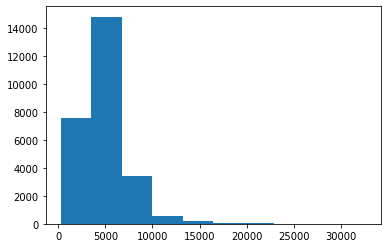

In [ ]:
# Check the distribution of our sequences at character-level
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=10);

In [ ]:
# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

8914

In [ ]:
# Get all keyboard characters for char-level embedding
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # num characters in alphabet + space + OOV token
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,  
                                    output_sequence_length=output_seq_char_len,
                                    standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")

# Adapt character vectorizer to training characters
char_vectorizer.adapt(train_chars)

In [ ]:
# Check character vocabulary characteristics
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 45
5 most common characters: ['', '[UNK]', 'e', 't', 'o']
5 least common characters: ['\x85', '\u2028', '\u202f', '\u2002', '\u2003']


In [ ]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n{random_train_chars}")
print(f"\nLength of chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
   A t t e n t i o n   t o   c u s t o m e r   s e r v i c e   c a n   b e   c r u c i a l   w h e n   d e a l i n g   w i t h   a   f l u x   o f   p e o p l e   w i t h   a l l   t y p e s   o f   r e q u e s t s .   T h i s   w e e k e n d ,   T h o m a s   i s   a i m i n g   t o   b e   a s   a c c o m m o d a t i n g   t o   W i l d c a t s   f a n s   a s   h e   i s   t o   t h e   l o c a l   C a r d i n a l s   f a n s .   Y o u   c a n   g a i n   a   l o t   o f   b u s i n e s s   f r o m   f a n s   o f   v i s i t i n g   t e a m s   a n d   t h e y   c a n   c o m e   b a c k   e v e r y   t i m e   t h e y   a r e   i n   t o w n ,   h e   s a y s .   H o w   d o   y o u   p r e p a r e   y o u r   b u s i n e s s   f o r   a   s a l e s   s u r g e   L e t   u s   k n o w   i n   t h e   c o m m e n t s   s e c t i o n   b e l o w .

Length of chars: 2215

Vectorized chars:
[[19  4  9 ...  0  0  0]]

Length of vectorized chars: 8914


In [ ]:
# Create char embedding layer
char_embed = layers.Embedding(input_dim=NUM_CHAR_TOKENS,
                              output_dim=25, # embedding dimension of each character
                              mask_zero=True,
                              name="char_embed")



In [ ]:
# Test out character embedding layer
print(f"Charified text (before vectorization and embedding):\n{random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text (before vectorization and embedding):
   A t t e n t i o n   t o   c u s t o m e r   s e r v i c e   c a n   b e   c r u c i a l   w h e n   d e a l i n g   w i t h   a   f l u x   o f   p e o p l e   w i t h   a l l   t y p e s   o f   r e q u e s t s .   T h i s   w e e k e n d ,   T h o m a s   i s   a i m i n g   t o   b e   a s   a c c o m m o d a t i n g   t o   W i l d c a t s   f a n s   a s   h e   i s   t o   t h e   l o c a l   C a r d i n a l s   f a n s .   Y o u   c a n   g a i n   a   l o t   o f   b u s i n e s s   f r o m   f a n s   o f   v i s i t i n g   t e a m s   a n d   t h e y   c a n   c o m e   b a c k   e v e r y   t i m e   t h e y   a r e   i n   t o w n ,   h e   s a y s .   H o w   d o   y o u   p r e p a r e   y o u r   b u s i n e s s   f o r   a   s a l e s   s u r g e   L e t   u s   k n o w   i n   t h e   c o m m e n t s   s e c t i o n   b e l o w .

Embedded chars (after vectorization and embedding):
[[[-0.01891696 -0.01977515 -0.0

Input (character-level text) -> Tokenize -> Embedding -> Layers (Conv1D, GlobalMaxPool1D) -> Output (label probability)

In [ ]:
# Make Conv1D on chars only
inputs = layers.Input(shape=(1,), dtype="string")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_3 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_3_conv1D_char_embedding")

# Compile model
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Check the summary of conv1d_char_model
model_3.summary()

Model: "model_3_conv1D_char_embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
char_vectorizer (TextVectori (None, 8914)              0         
_________________________________________________________________
char_embed (Embedding)       (None, 8914, 25)          1750      
_________________________________________________________________
conv1d (Conv1D)              (None, 8914, 64)          8064      
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 5)                 325       
Total params: 10,139
Trainable params: 10,139
Non-trainable params: 0
_________________________________

In [ ]:
# Create char datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

In [ ]:
# create checkpoint
model_3_path = '/content/drive/MyDrive/AI-ML/models/model_3_path'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(model_3_path, save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)
# Fit the model
model_3_history = model_3.fit(train_dataset,
                              steps_per_epoch=int(len(train_dataset)), 
                              epochs=5,
                              validation_data=valid_dataset,
                              validation_steps=int(len(valid_dataset)),
                              callbacks = [model_checkpoint])

Epoch 1/5
834/834 [==============================] - 40s 31ms/step - loss: 1.5523 - accuracy: 0.2970 - val_loss: 1.5458 - val_accuracy: 0.3141

Epoch 00001: val_accuracy improved from -inf to 0.31410, saving model to /content/drive/MyDrive/AI-ML/models/model_3_path
INFO:tensorflow:Assets written to: /content/drive/MyDrive/AI-ML/models/model_3_path/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/AI-ML/models/model_3_path/assets


Epoch 2/5
834/834 [==============================] - 26s 31ms/step - loss: 1.5284 - accuracy: 0.3202 - val_loss: 1.5429 - val_accuracy: 0.3134

Epoch 00002: val_accuracy did not improve from 0.31410
Epoch 3/5
834/834 [==============================] - 26s 31ms/step - loss: 1.5221 - accuracy: 0.3252 - val_loss: 1.5407 - val_accuracy: 0.3175

Epoch 00003: val_accuracy improved from 0.31410 to 0.31748, saving model to /content/drive/MyDrive/AI-ML/models/model_3_path
INFO:tensorflow:Assets written to: /content/drive/MyDrive/AI-ML/models/model_3_path/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/AI-ML/models/model_3_path/assets


Epoch 4/5
834/834 [==============================] - 26s 31ms/step - loss: 1.5172 - accuracy: 0.3277 - val_loss: 1.5392 - val_accuracy: 0.3168

Epoch 00004: val_accuracy did not improve from 0.31748
Epoch 5/5
834/834 [==============================] - 26s 31ms/step - loss: 1.5131 - accuracy: 0.3315 - val_loss: 1.5374 - val_accuracy: 0.3178

Epoch 00005: val_accuracy improved from 0.31748 to 0.31781, saving model to /content/drive/MyDrive/AI-ML/models/model_3_path
INFO:tensorflow:Assets written to: /content/drive/MyDrive/AI-ML/models/model_3_path/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/AI-ML/models/model_3_path/assets


In [ ]:
#ReLoad the best model
model_3 =  tf.keras.models.load_model(model_3_path)

In [ ]:
# Evaluate model_3 on whole validation char dataset
model_3.evaluate(val_char_dataset)

93/93 [==============================] - 3s 26ms/step - loss: 2.3131 - accuracy: 0.2082


[2.313093662261963, 0.20816464722156525]

In [ ]:
# Make predictions with character model only
model_3_pred_probs = model_3.predict(val_char_dataset)
#model_3_pred_probs
# Convert predictions to classes
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
#model_3_preds

# Calculate Conv1D char only model results
model_3_results = calculate_results(y_true=val_labels_encoded,
                                        y_pred=model_3_preds)
model_3_results

{'accuracy': 20.81646423751687,
 'f1': 0.07294314241904296,
 'precision': 0.072174844244283,
 'recall': 0.20816464237516868}

In [ ]:
from sklearn.metrics import confusion_matrix , classification_report
print(confusion_matrix(val_labels_encoded, model_3_preds))
print(classification_report(val_labels_encoded, model_3_preds))

[[  2 469   0   0   0]
 [  1 615   0   0   0]
 [  2 720   0   0   0]
 [  0 542   0   0   0]
 [  6 607   0   0   0]]
              precision    recall  f1-score   support

           0       0.18      0.00      0.01       471
           1       0.21      1.00      0.34       616
           2       0.00      0.00      0.00       722
           3       0.00      0.00      0.00       542
           4       0.00      0.00      0.00       613

    accuracy                           0.21      2964
   macro avg       0.08      0.20      0.07      2964
weighted avg       0.07      0.21      0.07      2964



In [ ]:
# Save Model
#tf.keras.models.save_model(model_3, "/content/drive/MyDrive/AI-ML/models/model_3_path/")

##MODEL 3 SUMMARY -

With Character level embedding the model performed miserably with only 21% accuracy, which is worse than the baseline model. From confusion matrix it is evident that the model has put almost everything on just one class.



---



---



---



#Model 4: Combining pretrained token embeddings + character embeddings (hybrid embedding layer)

Inspired from the paper  "Neural Networks for Joint Sentence Classification in Medical Paper Abstracts",we will try a hybrid token embedding layer th, which is a  combination of token embeddings (USE used in model_1) and character embeddings (used in model_3). They create a stacked embedding to represent text sequences and passed on to the output  layer.

Quick Steps -

1. Create a token-level model (similar to model_2)
2. Create a character-level model  (similar to model_3)
3. Combine (using layers.Concatenate) the outputs of 1 and 2
4. output layers on top of 3 


In [ ]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [ ]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings)

token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_output)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)

char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings) # bi-LSTM 

char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output, 
                                                                  char_model.output])

# 4. Create output layers -
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(200, activation="relu")(combined_dropout) 
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")
# Get summary of token and character model
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
char_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
token_input (InputLayer)        [(None,)]            0                                            
__________________________________________________________________________________________________
char_vectorizer (TextVectorizat (None, 8914)         0           char_input[0][0]                 
__________________________________________________________________________________________________
universal_sentence_encoder (Ker (None, 512)          256797824   token_input[0][0]                
__________________________________________________________________

In [ ]:
# Compile token char model
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(), 
                metrics=["accuracy"])


Let's create a tf.data.Dataset with a tuple as it's first input, for example:

((token_data, char_data), (label))


In [ ]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels
# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) 

# Repeat same steps validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Check out training char and token embedding dataset
train_char_token_dataset, val_char_token_dataset


(<PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.float64)>,
 <PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.float64)>)

In [ ]:
# create checkpoint
model_4_path = '/content/drive/MyDrive/AI-ML/models/model_4_path'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(model_4_path, save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)

# Fit the model on tokens and chars
model_4_history = model_4.fit(train_char_token_dataset, # train on dataset of token and characters
                              steps_per_epoch=int(len(train_char_token_dataset)),
                              epochs=5,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(len(val_char_token_dataset)),
                              callbacks = [model_checkpoint])

Epoch 1/5
834/834 [==============================] - 500s 589ms/step - loss: 0.8392 - accuracy: 0.6828 - val_loss: 0.7148 - val_accuracy: 0.7257

Epoch 00001: val_accuracy improved from -inf to 0.72571, saving model to /content/drive/MyDrive/AI-ML/models/model_4_path


INFO:tensorflow:Assets written to: /content/drive/MyDrive/AI-ML/models/model_4_path/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/AI-ML/models/model_4_path/assets


Epoch 2/5
834/834 [==============================] - 491s 589ms/step - loss: 0.7216 - accuracy: 0.7245 - val_loss: 0.6935 - val_accuracy: 0.7321

Epoch 00002: val_accuracy improved from 0.72571 to 0.73212, saving model to /content/drive/MyDrive/AI-ML/models/model_4_path


INFO:tensorflow:Assets written to: /content/drive/MyDrive/AI-ML/models/model_4_path/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/AI-ML/models/model_4_path/assets


Epoch 3/5
834/834 [==============================] - 494s 592ms/step - loss: 0.6973 - accuracy: 0.7312 - val_loss: 0.6830 - val_accuracy: 0.7368

Epoch 00003: val_accuracy improved from 0.73212 to 0.73684, saving model to /content/drive/MyDrive/AI-ML/models/model_4_path


INFO:tensorflow:Assets written to: /content/drive/MyDrive/AI-ML/models/model_4_path/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/AI-ML/models/model_4_path/assets


Epoch 4/5
834/834 [==============================] - 495s 593ms/step - loss: 0.6806 - accuracy: 0.7396 - val_loss: 0.6821 - val_accuracy: 0.7382

Epoch 00004: val_accuracy improved from 0.73684 to 0.73819, saving model to /content/drive/MyDrive/AI-ML/models/model_4_path


INFO:tensorflow:Assets written to: /content/drive/MyDrive/AI-ML/models/model_4_path/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/AI-ML/models/model_4_path/assets


Epoch 5/5
834/834 [==============================] - 496s 594ms/step - loss: 0.6725 - accuracy: 0.7420 - val_loss: 0.6861 - val_accuracy: 0.7375

Epoch 00005: val_accuracy did not improve from 0.73819


In [ ]:
#ReLoad the best model
model_4 =  tf.keras.models.load_model(model_4_path)
# Evaluate on the whole validation dataset
model_4.evaluate(val_char_token_dataset)

93/93 [==============================] - 31s 296ms/step - loss: 0.6821 - accuracy: 0.7382


[0.6820693612098694, 0.7381916046142578]

In [ ]:
val_char_token_dataset

<PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.float64)>

In [ ]:
# Make predictions using the token-character model hybrid
model_4_pred_probs = model_4.predict(val_char_token_dataset)
#model_4_pred_probs
# Turn prediction probabilities into prediction classes
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
#model_4_preds
# Get results of token-char-hybrid model
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 73.8191632928475,
 'f1': 0.7291461384385695,
 'precision': 0.7293254345902603,
 'recall': 0.738191632928475}

In [ ]:
from sklearn.metrics import confusion_matrix , classification_report
print(confusion_matrix(val_labels_encoded, model_4_preds))
print(classification_report(val_labels_encoded, model_4_preds))

[[422  12  14  12  11]
 [ 16 466  39  88   7]
 [  8  20 611  39  44]
 [ 34 133 125 211  39]
 [ 27  21  62  25 478]]
              precision    recall  f1-score   support

           0       0.83      0.90      0.86       471
           1       0.71      0.76      0.74       616
           2       0.72      0.85      0.78       722
           3       0.56      0.39      0.46       542
           4       0.83      0.78      0.80       613

    accuracy                           0.74      2964
   macro avg       0.73      0.73      0.73      2964
weighted avg       0.73      0.74      0.73      2964



#MODEL 4 RESULTS ANALYSIS -

Model 4 is a complex model with 256M+ Non-trainable params from USE embedding layer and 114K+ Trainable params for character embedding and BiLSTM and Dense layers. It takes longer to train, however surprisingly accuracy remaind stagnant at 74% with F1 Score of 0.73. The results are similar to that of simple USE model_2. This signifies that the char embedding and other BiLSTM 
layers added did not provide any significant advantage.

---



---



#MODEL 4B - Variation of Hybrid embedding model_4

We then expreimented with leaky RELU activation and some additional DropOuts in embedding. 

In [ ]:

lrelu = lambda x: tf.keras.activations.relu(x, alpha=0.1)
# 1. Setup token inputs/model
token_inputsB = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddingsB = tf_hub_embedding_layer(token_inputsB)
token_outputB = layers.Dense(64, activation=lrelu)(token_embeddingsB)
step1_dropoutB = layers.Dropout(0.5)(token_outputB)
token_output1B = layers.Dense(32, activation=lrelu)(step1_dropoutB)
step1_dropout2B = layers.Dropout(0.5)(token_output1B)
token_modelB = tf.keras.Model(inputs=token_inputsB,
                             outputs=step1_dropout2B)

# 2. Setup char inputs/model
char_inputsB = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectorsB = char_vectorizer(char_inputsB)
char_embeddingsB = char_embed(char_vectorsB)

char_bi_lstmB = layers.Bidirectional(layers.GRU(50))(char_embeddingsB) # bi-LSTM 

char_modelB = tf.keras.Model(inputs=char_inputsB,
                            outputs=char_bi_lstmB)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concatB = layers.Concatenate(name="token_char_hybrid")([token_modelB.output, 
                                                                  char_modelB.output])

# 4. Create output layers -
combined_dropoutB = layers.Dropout(0.5)(token_char_concatB)
#combined_flat = layers.Dropout(0.5)(combined_dropout)
combined_denseB = layers.Dense(100, activation=lrelu)(combined_dropoutB)
combined_dropout2B = layers.Dropout(0.5)(combined_denseB)
combined_dense2B = layers.Dense(20, activation=lrelu)(combined_dropout2B) 
final_dropoutB = layers.Dropout(0.5)(combined_dense2B)

output_layerB = layers.Dense(num_classes, activation="softmax")(final_dropoutB)

# 5. Construct model with char and token inputs
model_4B = tf.keras.Model(inputs=[token_modelB.input, char_modelB.input],
                         outputs=output_layerB,
                         name="model_4B_token_and_char_embeddings")
# Get summary of token and character model
model_4B.summary()

Model: "model_4B_token_and_char_embeddings"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
token_input (InputLayer)        [(None,)]            0                                            
__________________________________________________________________________________________________
universal_sentence_encoder (Ker (None, 512)          256797824   token_input[0][0]                
__________________________________________________________________________________________________
dense_21 (Dense)                (None, 64)           32832       universal_sentence_encoder[5][0] 
__________________________________________________________________________________________________
char_input (InputLayer)         [(None, 1)]          0                                            
_________________________________________________________________

In [ ]:
 #Compile token char model
model_4B.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(), 
                metrics=["accuracy"])

In [ ]:
# create checkpoint
model_4B_path = '/content/drive/MyDrive/AI-ML/models/model_4B_path'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(model_4B_path, save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)

# Fit the model on tokens and chars
model_4B_history = model_4B.fit(train_char_token_dataset, # train on dataset of token and characters
                              steps_per_epoch=int(len(train_char_token_dataset)),
                              epochs=5,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(len(val_char_token_dataset)),
                              callbacks = [model_checkpoint])

Epoch 1/5
834/834 [==============================] - 590s 702ms/step - loss: 1.3155 - accuracy: 0.4540 - val_loss: 0.8639 - val_accuracy: 0.6879

Epoch 00001: val_accuracy improved from -inf to 0.68792, saving model to /content/drive/MyDrive/AI-ML/models/model_4B_path


INFO:tensorflow:Assets written to: /content/drive/MyDrive/AI-ML/models/model_4B_path/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/AI-ML/models/model_4B_path/assets


Epoch 2/5
834/834 [==============================] - 584s 700ms/step - loss: 1.0276 - accuracy: 0.6312 - val_loss: 0.8134 - val_accuracy: 0.6920

Epoch 00002: val_accuracy improved from 0.68792 to 0.69197, saving model to /content/drive/MyDrive/AI-ML/models/model_4B_path


INFO:tensorflow:Assets written to: /content/drive/MyDrive/AI-ML/models/model_4B_path/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/AI-ML/models/model_4B_path/assets


Epoch 3/5
834/834 [==============================] - 585s 701ms/step - loss: 0.9675 - accuracy: 0.6558 - val_loss: 0.7850 - val_accuracy: 0.6991

Epoch 00003: val_accuracy improved from 0.69197 to 0.69906, saving model to /content/drive/MyDrive/AI-ML/models/model_4B_path


INFO:tensorflow:Assets written to: /content/drive/MyDrive/AI-ML/models/model_4B_path/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/AI-ML/models/model_4B_path/assets


Epoch 4/5
834/834 [==============================] - 584s 700ms/step - loss: 0.9358 - accuracy: 0.6648 - val_loss: 0.7672 - val_accuracy: 0.7078

Epoch 00004: val_accuracy improved from 0.69906 to 0.70783, saving model to /content/drive/MyDrive/AI-ML/models/model_4B_path


INFO:tensorflow:Assets written to: /content/drive/MyDrive/AI-ML/models/model_4B_path/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/AI-ML/models/model_4B_path/assets


Epoch 5/5
834/834 [==============================] - 596s 714ms/step - loss: 0.9072 - accuracy: 0.6761 - val_loss: 0.7601 - val_accuracy: 0.7082

Epoch 00005: val_accuracy improved from 0.70783 to 0.70816, saving model to /content/drive/MyDrive/AI-ML/models/model_4B_path


INFO:tensorflow:Assets written to: /content/drive/MyDrive/AI-ML/models/model_4B_path/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/AI-ML/models/model_4B_path/assets


In [ ]:
#ReLoad the best model
model_4B=  tf.keras.models.load_model(model_4B_path)
# Evaluate on the whole validation dataset
model_4B.evaluate(val_char_token_dataset)

93/93 [==============================] - 33s 318ms/step - loss: 0.7601 - accuracy: 0.7082


[0.7600746154785156, 0.708164632320404]

In [ ]:
# Make predictions using the token-character model hybrid
model_4B_pred_probs = model_4B.predict(val_char_token_dataset)
#model_4B_pred_probs
# Turn prediction probabilities into prediction classes
model_4B_preds = tf.argmax(model_4B_pred_probs, axis=1)
#model_4_preds
# Get results of token-char-hybrid model
model_4B_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4B_preds)
model_4B_results

{'accuracy': 70.81646423751687,
 'f1': 0.6643590190579027,
 'precision': 0.676350416514463,
 'recall': 0.7081646423751687}

In [ ]:
from sklearn.metrics import confusion_matrix , classification_report
print(confusion_matrix(val_labels_encoded, model_4B_preds))
print(classification_report(val_labels_encoded, model_4B_preds))

[[428   8  16   6  13]
 [ 20 518  40  32   6]
 [ 12  20 632  19  39]
 [ 50 229 164  51  48]
 [ 32  26  80   5 470]]
              precision    recall  f1-score   support

           0       0.79      0.91      0.85       471
           1       0.65      0.84      0.73       616
           2       0.68      0.88      0.76       722
           3       0.45      0.09      0.16       542
           4       0.82      0.77      0.79       613

    accuracy                           0.71      2964
   macro avg       0.68      0.70      0.66      2964
weighted avg       0.68      0.71      0.66      2964



In [ ]:
# Save Model
#tf.keras.models.save_model(model_4, "/content/drive/MyDrive/AI-ML/models/model_4_path/")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/AI-ML/models/model_4_path/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/AI-ML/models/model_4_path/assets


#MODEL 4B Results Analysis- 

Changing form RELU to Leaky RELU activation and other tweaks did not help and instead Accuracy dropped from 74% to 71%.
So we can discrad this model


---



---



#Model 5 - LSTM with GloVE embeddings

Since we had the best performing model as of now from pretrained Sentence embedding (USE), it is worth trying to use other token embedding technique. We will now select  GLoVE embedding which is tokenized at word level with 300 dimensions and see if the results are promising.

---



---



In [ ]:
#Tokenize 
max_features = 40000
maxlen = 800 ##changed from 512
embedding_size = 300 ##changed from 30d

from keras.preprocessing.text import Tokenizer

token = Tokenizer(num_words = max_features)
# fit on text data
token.fit_on_texts(data_shuffled['Cleaned_Article_Text'])
#convert to sequence
X = token.texts_to_sequences(data_shuffled['Cleaned_Article_Text'])


print('no of samples : ' , len(X))
print(X[0])
print(len(token.word_index))

no of samples :  29631
[1, 476, 2792, 10, 28, 3980, 312, 18529, 368, 84, 1574, 312, 74, 2, 1, 6992, 305, 13, 106, 28, 524, 3194, 3088, 28, 1, 8719, 317, 8, 4666, 461, 6, 26, 57, 1441, 5, 6992, 5933, 114, 11031, 18, 84, 4471, 6, 366, 469, 710, 633, 2, 1475, 3, 26, 57, 1441, 5, 4666, 6992, 461, 55, 281, 469, 10063, 14, 22, 8011, 5, 100, 14, 64, 43, 234, 180, 281, 469, 36, 106, 3000, 619, 11927, 383, 704, 5, 63, 5933, 21, 1, 1512, 6, 1351, 5, 1, 140, 3, 557, 147, 21, 1, 2189, 6, 1351, 63, 2185, 242, 16, 1185, 34, 699, 2, 1, 6992, 787, 469, 265, 534, 5, 17, 1944, 388, 84, 667, 15, 1, 528, 6, 43, 291, 18, 237, 89, 16, 1711, 85, 18, 21572, 34, 644, 1, 4100, 18, 1, 3023, 27, 1, 454, 6083, 1, 140, 11, 1, 643, 773, 16, 6, 1441, 5, 1, 5933, 237, 178, 231, 1202, 6, 3686, 671, 461, 1146, 1, 505, 1307, 381, 5, 323, 1107, 118, 632, 4666, 7012, 3, 671, 461, 305, 774, 2216, 17, 80, 2656, 17, 671, 1370, 408, 38, 21, 7, 645, 120, 239, 1205, 438, 1509, 3964, 31, 671, 461, 4973, 1302, 19, 16, 314, 6, 2403

In [ ]:
#Padding
from tensorflow.keras.preprocessing.sequence import pad_sequences
X = pad_sequences(X, maxlen= maxlen, truncating="pre", padding="pre")
y = np.asarray(data_shuffled['Domain'])
print(X.shape)
print(y.shape)

(29631, 800)
(29631,)


In [ ]:
#Check no of words in Dict
num_words = len(token.word_index) +1
print('Total number of words in the dictionary :' , num_words)

Total number of words in the dictionary : 208961


In [ ]:
#Import GloVE embedding
#embedding_file = '/content/drive/MyDrive/AI-ML/Data/glove.6B.50d.txt'
embedding_file = '/content/drive/MyDrive/AI-ML/Data/glove.6B.300d.txt'
embedding = {}

for o in open(embedding_file):
  word = o.split(" ")[0]
  embd = np.asarray(o.split(" ")[1:], dtype = 'float32')
  embedding[word]= embd
  
len(embedding)

400000

In [ ]:
#Create Weight Matrix for Training
embedding_matrix = np.zeros((num_words, 300)) ## changed from 50 to 300

for word, i in token.word_index.items():
  if word in embedding.keys():
    embedding_matrix[i] = embedding[word]

embedding_matrix.shape

(208961, 300)

In [ ]:
#Target Features
np.unique(y)

array(['Finance', 'Leadership', 'Marketing', 'Strategy', 'Technology'],
      dtype=object)

In [ ]:
#first label encode text to numbers
from sklearn.preprocessing import LabelEncoder
import numpy as np


label_encoder = LabelEncoder()
y_le = label_encoder.fit_transform(y)

In [ ]:
#now one hot encode
from tensorflow.keras.utils import to_categorical
y_en = to_categorical(y_le)
y_en

array([[0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       ...,
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.]], dtype=float32)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_en, random_state=42, test_size=0.1)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(26667, 800) (2964, 800)
(26667, 5) (2964, 5)


In [ ]:
X_test

array([[ 429,    2, 4273, ...,    6, 2814,  354],
       [   0,    0,    0, ...,    3,  281,  319],
       [   0,    0,    0, ...,  737,    4,  509],
       ...,
       [  47,  526,    8, ...,    6,    9,  778],
       [ 184,   30,  133, ...,  348,    9, 1299],
       [   1,   47, 4495, ...,   12, 7353,  352]], dtype=int32)

In [ ]:
from tensorflow.keras import layers
import tensorflow_hub as hub
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LSTM, Dropout, Embedding, TimeDistributed, Bidirectional, GRU,Conv1D
from tensorflow.keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate, SpatialDropout1D

In [ ]:




#from tensorflow.keras import layers
lrelu = lambda x: tf.keras.activations.relu(x, alpha=0.1)

import tensorflow as tf
#Initialize model
tf.keras.backend.clear_session()
model_5 = tf.keras.Sequential()
model_5.add(Embedding(num_words,embedding_size, weights = [embedding_matrix], input_length= maxlen))
#model_5.add(Bidirectional(LSTM(200,return_sequences=True, dropout=0.2)))
model_5.add(Bidirectional(LSTM(units=200, return_sequences=True, dropout=0.2), merge_mode="concat")) # Default Activation Function is "tanh" is used here
#Add a TimeDistributed layer with 100 Dense neurons
model_5.add(TimeDistributed(Dense(200, activation=lrelu)))

model_5.add(LSTM(128, return_sequences = True))
model_5.add(Flatten())
model_5.add(Dense(128, activation = lrelu))
model_5.add(Dropout(0.5))
model_5.add(Dense(64, activation = lrelu))
model_5.add(Dropout(0.5))
model_5.add(Dense(num_classes, activation = 'softmax'))

model_5.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 800, 300)          62688300  
_________________________________________________________________
bidirectional (Bidirectional (None, 800, 400)          801600    
_________________________________________________________________
time_distributed (TimeDistri (None, 800, 200)          80200     
_________________________________________________________________
lstm_1 (LSTM)                (None, 800, 128)          168448    
_________________________________________________________________
flatten (Flatten)            (None, 102400)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               13107328  
_________________________________________________________________
dropout (Dropout)            (None, 128)               0

In [ ]:
# create checkpoint
model_5_path = '/content/drive/MyDrive/AI-ML/models/model_5_path'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(model_5_path, save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)


In [ ]:
model_5.compile(loss ='categorical_crossentropy', optimizer= 'adam', metrics =['accuracy'])

model_5_history = model_5.fit(X_train, y_train, validation_data= (X_test,y_test), epochs = 10, batch_size =100,callbacks = [model_checkpoint])

Epoch 1/10
267/267 [==============================] - 158s 572ms/step - loss: 1.0909 - accuracy: 0.5987 - val_loss: 0.7592 - val_accuracy: 0.7190

Epoch 00001: val_accuracy improved from -inf to 0.71896, saving model to /content/drive/MyDrive/AI-ML/models/model_5_path


INFO:tensorflow:Assets written to: /content/drive/MyDrive/AI-ML/models/model_5_path/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/AI-ML/models/model_5_path/assets


Epoch 2/10
267/267 [==============================] - 153s 572ms/step - loss: 0.7801 - accuracy: 0.7119 - val_loss: 0.7431 - val_accuracy: 0.7156

Epoch 00002: val_accuracy did not improve from 0.71896
Epoch 3/10
267/267 [==============================] - 156s 584ms/step - loss: 0.6626 - accuracy: 0.7545 - val_loss: 0.7585 - val_accuracy: 0.7203

Epoch 00003: val_accuracy improved from 0.71896 to 0.72031, saving model to /content/drive/MyDrive/AI-ML/models/model_5_path


INFO:tensorflow:Assets written to: /content/drive/MyDrive/AI-ML/models/model_5_path/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/AI-ML/models/model_5_path/assets


Epoch 4/10
267/267 [==============================] - 143s 534ms/step - loss: 0.5437 - accuracy: 0.7980 - val_loss: 0.7802 - val_accuracy: 0.7166

Epoch 00004: val_accuracy did not improve from 0.72031
Epoch 5/10
267/267 [==============================] - 143s 534ms/step - loss: 0.4455 - accuracy: 0.8352 - val_loss: 0.8673 - val_accuracy: 0.7065

Epoch 00005: val_accuracy did not improve from 0.72031
Epoch 6/10
267/267 [==============================] - 142s 533ms/step - loss: 0.3465 - accuracy: 0.8767 - val_loss: 0.9940 - val_accuracy: 0.6947

Epoch 00006: val_accuracy did not improve from 0.72031
Epoch 7/10
267/267 [==============================] - 142s 530ms/step - loss: 0.2800 - accuracy: 0.9052 - val_loss: 1.1586 - val_accuracy: 0.6953

Epoch 00007: val_accuracy did not improve from 0.72031
Epoch 8/10
267/267 [==============================] - 142s 533ms/step - loss: 0.2325 - accuracy: 0.9227 - val_loss: 1.0932 - val_accuracy: 0.6950

Epoch 00008: val_accuracy did not improve fro

In [ ]:
# Make predictions with feature extraction model
model_5_pred_probs = model_5.predict(X_test)
#model_5_pred_probs
# Convert the predictions with feature extraction model to classes
model_5_preds = np.argmax(model_5_pred_probs, axis=1)
model_5_preds

array([1, 3, 2, ..., 1, 2, 0])

In [ ]:
Y_test = np.argmax(y_test,  axis =1)

In [ ]:
model_5_results = calculate_results(y_true=Y_test,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 69.73684210526315,
 'f1': 0.6937256638427568,
 'precision': 0.6938634399395064,
 'recall': 0.6973684210526315}

In [ ]:
from sklearn.metrics import confusion_matrix , classification_report
print(confusion_matrix(Y_test, model_5_preds))
print(classification_report(Y_test, model_5_preds))

[[385  13  22  21  30]
 [ 16 421  46 124   9]
 [  7  29 584  60  42]
 [ 35 145 117 221  24]
 [ 25  26  70  36 456]]
              precision    recall  f1-score   support

           0       0.82      0.82      0.82       471
           1       0.66      0.68      0.67       616
           2       0.70      0.81      0.75       722
           3       0.48      0.41      0.44       542
           4       0.81      0.74      0.78       613

    accuracy                           0.70      2964
   macro avg       0.69      0.69      0.69      2964
weighted avg       0.69      0.70      0.69      2964



In [ ]:
# Save Model
tf.keras.models.save_model(model_5, "/content/drive/MyDrive/AI-ML/models/model_5_path_new/")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/AI-ML/models/model_5_path_new/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/AI-ML/models/model_5_path_new/assets


#MODEL 5 RESULTS ANALYSIS -

With 76M+ parameters with GloVE embedding, BiLSTM and Timedistributed layers we reached an Accuracy of 70% with F1 score of 0.69. Predicting 'Strategy' class remains the most challenging with only 0.44 F1 score. This model could not beat our earlier best model_2 using pretrained USE. 

In [ ]:

# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"Baseline_TF-IDF_Vectorize_MultinomialNB": baseline_results,
                                  "GLoVE_Embed_LSTM": model_5_results,
                                  "Custom_Token_Embed_Conv1D ": model_1_results,
                                  "Pretrained_Token_Embed(USE)_Conv1D": model_2_results,
                                  "Custom_Char_Embed_Conv1D ": model_3_results,
                                  "Hybrid_Char_Token_Embed_BiLSTM_1 ": model_4_results,
                                  "Hybrid_Char_Token_Embed_BiLSTM_2 ": model_4B_results
                                  })
all_model_results = all_model_results.transpose()
all_model_results.sort_values("f1")

,accuracy,precision,recall,f1
Custom_Char_Embed_Conv1D,20.8502024,0.0764386,0.2085020,0.0776745
Baseline_TF-IDF_Vectorize_MultinomialNB,61.7746289,0.6972105,0.6177463,0.5581375
Custom_Token_Embed_Conv1D,64.4399460,0.6693027,0.6443995,0.6526836
Hybrid_Char_Token_Embed_BiLSTM_2,70.8164642,0.6763504,0.7081646,0.6643590
GLoVE_Embed_LSTM,69.7368421,0.6938634,0.6973684,0.6937257
Hybrid_Char_Token_Embed_BiLSTM_1,73.8191633,0.7293254,0.7381916,0.7291461
Pretrained_Token_Embed(USE)_Conv1D,73.8191633,0.7314554,0.7381916,0.7314738


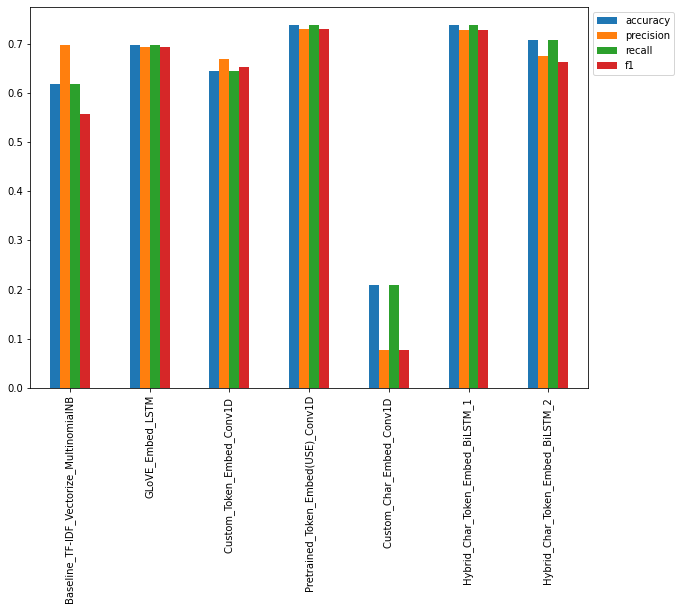

In [ ]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0))

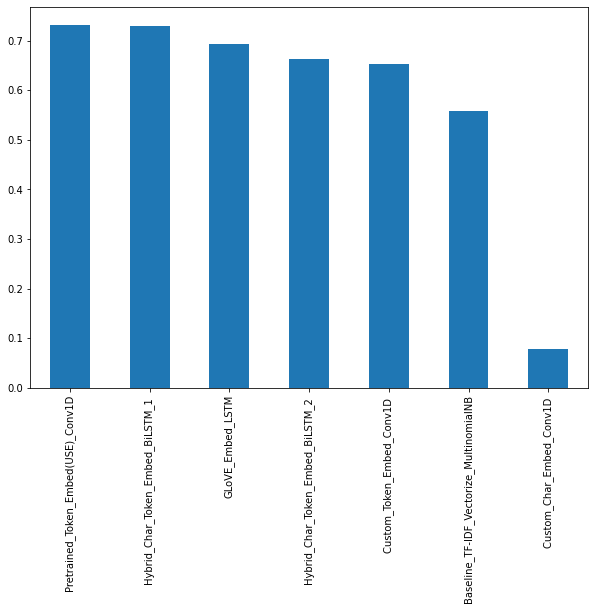

In [ ]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));

Text(0.5, 0, 'F1-Score')

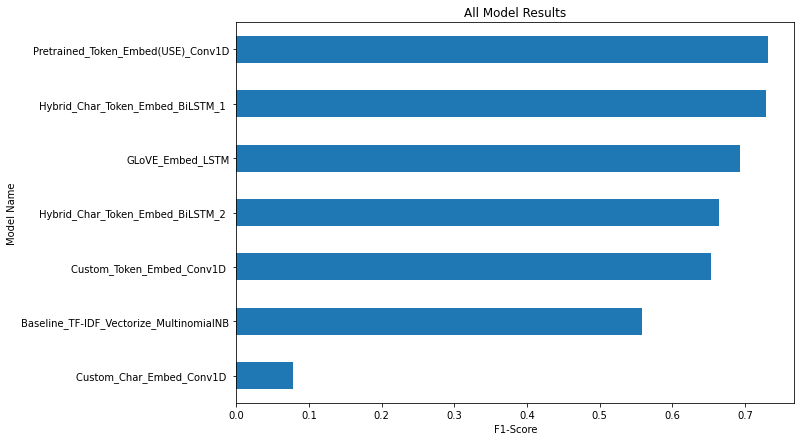

In [ ]:
from matplotlib import pyplot as plt
all_model_results.sort_values("f1", ascending=True)["f1"].plot(kind="barh", figsize=(10, 7), title="All Models")
plt.title("All Model Results")
plt.ylabel("Model Name")
plt.xlabel("F1-Score")

In [ ]:
df_results = all_model_results.sort_values("f1", ascending=False)
df_results.info()

NameError: ignored

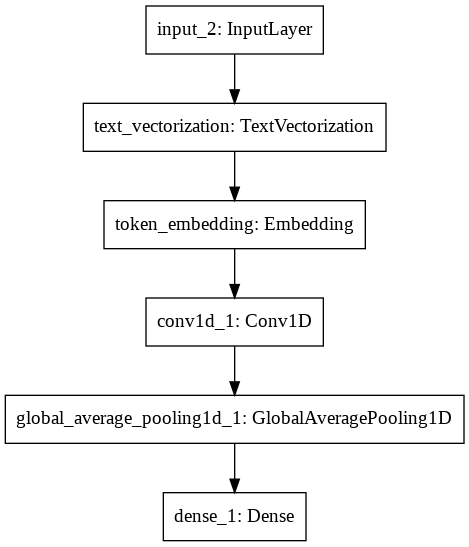

In [ ]:
tensorflow.keras.utils.plot_model(model_1,to_file ='model_1.png')

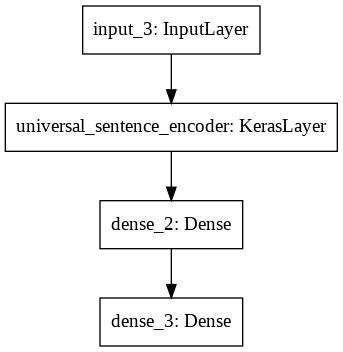

In [ ]:
tensorflow.keras.utils.plot_model(model_2,to_file ='model_2.png')

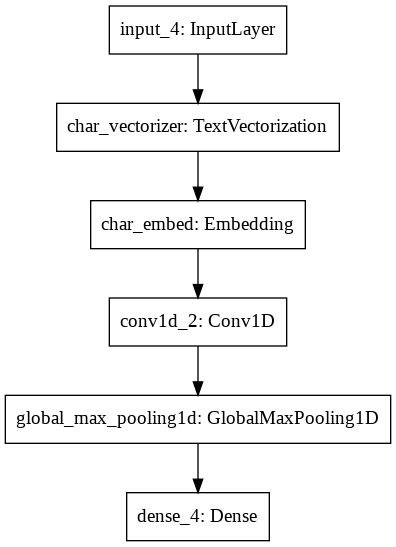

In [ ]:
tensorflow.keras.utils.plot_model(model_3,to_file ='model_3.png')

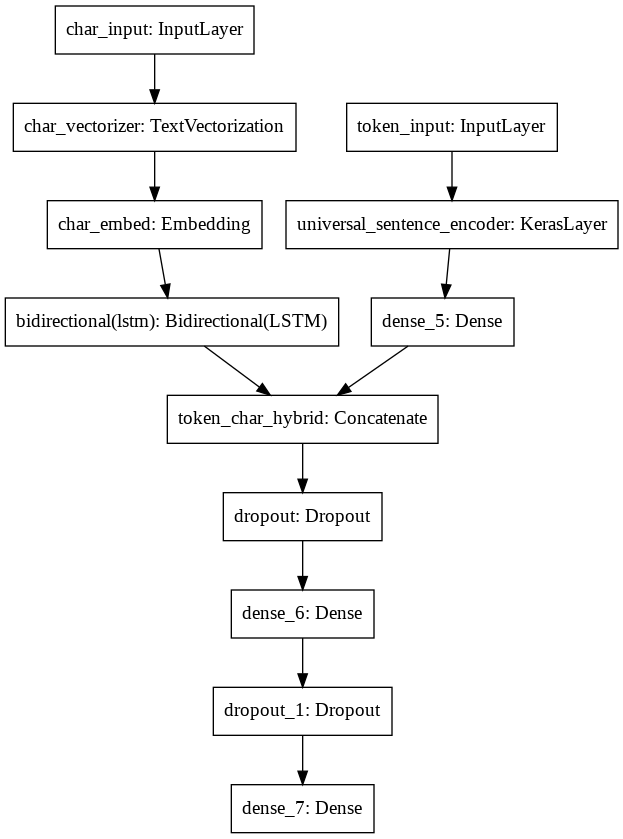

In [ ]:
tensorflow.keras.utils.plot_model(model_4,to_file ='model_4.png')

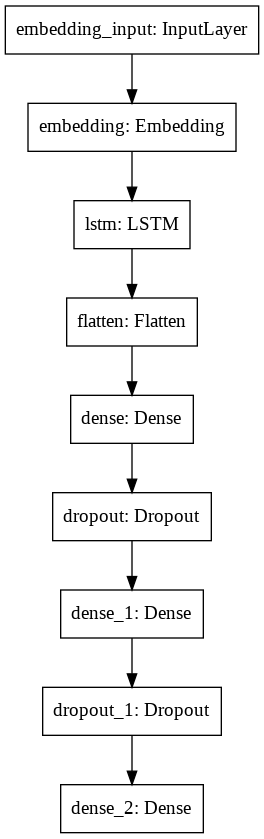

In [ ]:
tensorflow.keras.utils.plot_model(model_5,to_file ='model_5.png')

In [ ]:
###########################################

## Saving and loading a trained model to Predict


In [ ]:
#path = "/content/drive/MyDrive/AI-ML/Data/TestAtricle1MarketingMedium.docx"
path = "/content/drive/MyDrive/AI-ML/Data/TestArticle3_Finance_Large.docx"
'''
### read in the .docx file extention
'''
import docx

doc = docx.Document(path)
doc_data = [p.text for p in doc.paragraphs if p.text]

doc_data_str = ''
for p in doc.paragraphs:
  doc_data_str  += str(p.text)   

new_df = pd.DataFrame({'Article_Text': [doc_data_str]})

In [ ]:
###########################################################
#### The below function is on Text Preprocessing File

#Clean up the new article using same function as done for train-test datasets
from bs4 import BeautifulSoup
import re

def str_strip(text):
    soup = BeautifulSoup(text, "html.parser") 
    text = re.sub('\[[^]]*\]', '', soup.get_text())
    text = re.sub('\nAuthor Abstract\n', '', text)
    text = re.sub('(?=Paper Information)(?s)(.*$)', '', text)
    text = text.strip()
    text = re.sub('\n', ' ', text)
    text = re.sub('\t', ' ', text)
    text = re.sub(u'\xa0', u' ', text)
    text = re.sub('—', ' ', text)  
    pattern=r"[^a-zA-z0-9\s,.;!()&$\-']"
    text=re.sub(pattern,'',text)
    text = re.sub('/\s\s+/g', ' ', text) #remove multiple spaces
    text = re.sub('/  +/g', ' ',text)
    read_pattern1 =r'\d min read'
    read_pattern2 =r'min read'
    translation_pattern = r'This article was translated from our Spanish edition using AI technologies. Errors may exist due to this process.'
    opinion_pattern = 'Opinions expressed by Entrepreneur contributors are their own.'
    date_pattern = r'^(?:January|February|March|April|May|June|July|August|September|October|November|December)\s+(\d+)\,\s+(\d+)\s+' 
    text=re.sub(read_pattern1,'',text)
    text=re.sub(read_pattern2,'',text)
    text=re.sub(translation_pattern,'',text)
    text=re.sub(opinion_pattern,'',text)
    text=re.sub(date_pattern,'',text)
    return text

In [ ]:
new_df['Cleaned_Article']=new_df['Article_Text'].apply(str_strip)
article_to_predict = new_df['Cleaned_Article'][0]

In [ ]:
#Function to reverse map predicted domain value to name
# We need it when we dont have access to label encoder object created during training
#convertng into category
def domain_mapping(x):
    if (x == 0):
        ret = "Finance"  
    elif (x == 1 ):
        ret = "Leadership"
    elif (x == 2 ):
        ret = "Marketing"
    elif (x == 3 ):
        ret = "ENStrategyTP"
    elif (x == 4 ):
        ret = "Technology"
    return ret    

## MODEL 0 PREDICTION

In [ ]:
# load the model_0 from disk
model_0_path = "/content/drive/MyDrive/AI-ML/models/model_0_path/model_0.sav"
loaded_model_0 = pickle.load(open(model_0_path, 'rb'))
loaded_model_0_predicted_class = loaded_model_0.predict([article_to_predict])
print(loaded_model_0_predicted_class)

[1]


In [ ]:
predicted_domain_model_0 =label_encoder.inverse_transform(loaded_model_0_predicted_class)
predicted_domain_model_0

array(['Leadership'], dtype=object)

##MODEL 1 PREDICTION

In [ ]:
model_1_path = "/content/drive/MyDrive/AI-ML/models/model_1_path/"
loaded_model_1 = tf.keras.models.load_model(model_1_path)
loaded_model_1.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 500)               0         
_________________________________________________________________
token_embedding (Embedding)  (None, 500, 128)          3840000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 500, 64)           41024     
_________________________________________________________________
global_average_pooling1d_1 ( (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 325       
Total params: 3,881,349
Trainable params: 3,881,349
Non-trainable params: 0
_________________________________________________

In [ ]:
loaded_model_1_pred_probs = loaded_model_1.predict([article_to_predict])
loaded_model_1_pred = tf.argmax(loaded_model_1_pred_probs, axis=1)
loaded_model_1_pred
predicted_domain_model_1 =label_encoder.inverse_transform(loaded_model_1_pred)
predicted_domain_model_1

array(['Finance'], dtype=object)

## MODEL 2 PREDICTION

In [ ]:
model_2_path = "/content/drive/MyDrive/AI-ML/models/model_2_path/"
loaded_model_2 = tf.keras.models.load_model(model_2_path)
loaded_model_2.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None,)]                 0         
_________________________________________________________________
universal_sentence_encoder ( (None, 512)               256797824 
_________________________________________________________________
dense_2 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 645       
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
#####. NOT SURE IF THIS IS REQUIRE IN SEPRATE FILE

# The pretrained USE module from TensorFlow Hub takes care of tokenizing 
# and outputs a 512 dimensional embedding vector
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [ ]:
loaded_model_2_pred_probs = loaded_model_2.predict([article_to_predict])
loaded_model_2_pred = tf.argmax(loaded_model_2_pred_probs, axis=1)
loaded_model_2_pred
predicted_domain_model_2 =label_encoder.inverse_transform(loaded_model_2_pred)
predicted_domain_model_2

array(['Finance'], dtype=object)

## MODEL 3 PREDICTION

In [ ]:
model_3_path = "/content/drive/MyDrive/AI-ML/models/model_3_path/"
loaded_model_3 = tf.keras.models.load_model(model_3_path)
loaded_model_3.summary()

Model: "model_3_conv1D_char_embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
char_vectorizer (TextVectori (None, 8908)              0         
_________________________________________________________________
char_embed (Embedding)       (None, 8908, 25)          1750      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 8908, 64)          8064      
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 325       
Total params: 10,139
Trainable params: 10,139
Non-trainable params: 0
_________________________________

In [ ]:
#####. NOT SURE IF THIS IS REQUIRE IN SEPRATE FILE
"""
# Make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]

# Get all keyboard characters for char-level embedding
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # num characters in alphabet + space + OOV token
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,  
                                    output_sequence_length=output_seq_char_len,
                                    standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")

# Adapt character vectorizer to training characters
char_vectorizer.adapt(train_chars)

In [ ]:
loaded_model_3_pred_probs = loaded_model_3.predict([article_to_predict])
loaded_model_3_pred = tf.argmax(loaded_model_3_pred_probs, axis=1)
loaded_model_3_pred
predicted_domain_model_3 =label_encoder.inverse_transform(loaded_model_3_pred)
predicted_domain_model_3

array(['Finance'], dtype=object)

## MODEL 4 PREDICTION

In [ ]:
model_4_path = "/content/drive/MyDrive/AI-ML/models/model_4_path/"
loaded_model_4 = tf.keras.models.load_model(model_4_path)
loaded_model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
char_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
token_input (InputLayer)        [(None,)]            0                                            
__________________________________________________________________________________________________
char_vectorizer (TextVectorizat (None, 8908)         0           char_input[0][0]                 
__________________________________________________________________________________________________
universal_sentence_encoder (Ker (None, 512)          256797824   token_input[0][0]                
__________________________________________________________________

In [ ]:
# Split sequence-level data splits into character-level data splits
predict_chars = [split_chars(sentence) for sentence in article_to_predict]
len(predict_chars)

8832

In [ ]:
article_to_predict

"The past few weeks, our social feeds have been lit up with accounts of Silicon Valley's overt sexism. This isn't the kind of news that we've grown accustomed to. The kind that shares the stats about the gross underinvestment in female founders. No, our skin has already grown thick from repeated reminders of those cold facts. This was a new kind of news. The kind that was dirtier and darker than we'd wanted to imagine.A series of articles, filled with firsthand reports from female founders, has shone a black light on the stained sheets of Silicon Valley. We may have had our suspicions, but with the accounts from these brave women, the dirty laundry is finally being aired.Related 11 Grants for Women-Owned Businesses You Need to Know AboutIn case you missed it, the scandals kicked off with Justin Caldbeck. The co-founder of early stage investment fund Binary Capital was called out for inappropriately verbally and physically coming onto women entrepreneurs seeking funding from his firm. B

In [ ]:
predict_token_data = tf.data.Dataset.from_tensor_slices(([article_to_predict], ))

In [ ]:
predict_token_data

<TensorSliceDataset shapes: ((),), types: (tf.string,)>

In [ ]:
predict_char_data = tf.data.Dataset.from_tensor_slices((predict_chars, ))

In [ ]:
predict_char_data

<TensorSliceDataset shapes: ((),), types: (tf.string,)>

In [ ]:
predict_dataset = tf.data.Dataset.zip((predict_token_data, predict_char_data))

In [ ]:
#predict_char_dataset = tf.data.Dataset.from_tensor_slices((predict_chars, ))
#predict_token_dataset = tf.data.Dataset.from_tensor_slices(([article_to_predict], ))
predict_char_token_dataset = tf.data.Dataset.zip((predict_dataset,))
predict_char_token_dataset = predict_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
predict_char_token_dataset

<PrefetchDataset shapes: ((((None,),), ((None,),)),), types: (((tf.string,), (tf.string,)),)>

In [ ]:
loaded_model_4_pred_probs = loaded_model_4.predict(predict_char_token_dataset)
loaded_model_4_pred = tf.argmax(loaded_model_4_pred_probs, axis=1)
loaded_model_4_pred
predicted_domain_model_4 =label_encoder.inverse_transform(loaded_model_4_pred)
predicted_domain_model_4

array(['Finance'], dtype=object)

In [ ]:
#Another approach to prediction using mapping function

predicted_domain_model_4 = domain_mapping(loaded_model_4_pred)
predicted_domain_model_4

##MODEL 5 PREDICTION

In [ ]:
model_5_path = "/content/drive/MyDrive/AI-ML/models/model_5_path/"
loaded_model_5 = tf.keras.models.load_model(model_5_path)
loaded_model_5.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 512, 50)           9828000   
_________________________________________________________________
lstm (LSTM)                  (None, 512, 128)          91648     
_________________________________________________________________
flatten (Flatten)            (None, 65536)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               8388736   
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0

In [ ]:
#Tokenize 
max_features = 30000
maxlen = 512
embedding_size = 50

from keras.preprocessing.text import Tokenizer

token = Tokenizer(num_words = max_features)
# fit on text data
token.fit_on_texts(data_shuffled['Cleaned_Article_Text'])
#convert to sequence
X_new = token.texts_to_sequences([article_to_predict])


print('no of samples : ' , len(X_new))
print(X_new[0])
print(len(token.word_index))

no of samples :  1
[1, 375, 206, 1070, 71, 94, 3704, 21, 113, 10091, 51, 14, 930, 5, 1868, 18382, 12987, 12704, 20, 770, 1, 576, 5, 434, 8, 1647, 1898, 5683, 2, 1, 576, 8, 849, 1, 4326, 40, 1, 2818, 6, 1787, 842, 84, 71, 3594, 50, 303, 1898, 6946, 27, 5568, 4650, 5, 100, 1870, 2170, 20, 49, 4, 53, 576, 5, 434, 1, 576, 8, 49, 3, 14000, 57, 6126, 747, 2, 1412, 4, 1027, 5, 1445, 2521, 14, 4986, 1072, 27, 1787, 842, 50, 29204, 4, 1359, 1213, 12, 1, 26578, 5557, 5, 1868, 1883, 39, 89, 21, 114, 71, 24820, 28, 14, 1, 930, 27, 63, 6261, 462, 1, 5396, 7558, 10, 1047, 136, 9020, 45, 1189, 4307, 11, 462, 2004, 128, 7, 65, 2, 87, 414, 7, 2641, 13, 1, 9065, 6782, 189, 14, 7090, 1, 466, 376, 5, 377, 870, 368, 972, 12595, 392, 49, 535, 52, 11, 17984, 11131, 3, 3692, 669, 2059, 462, 153, 1509, 741, 27, 91, 543, 28, 13, 974, 715, 69, 115, 764, 1, 9841, 733, 5004, 17854, 1, 376, 5, 834, 492, 148, 3439, 179, 5228, 4260, 829, 31, 485, 43, 1787, 376, 17854, 11298, 27, 91, 382, 3639, 189, 12485, 897, 4, 974

In [ ]:
#Padding
from tensorflow.keras.preprocessing.sequence import pad_sequences
X_new = pad_sequences(X_new, maxlen= maxlen, truncating="pre", padding="pre")

print(X_new.shape)


(1, 512)


In [ ]:
loaded_model_5_pred_probs = loaded_model_5.predict(X_new)
loaded_model_5_pred = tf.argmax(loaded_model_5_pred_probs, axis=1)
loaded_model_5_pred
predicted_domain_model_5 =label_encoder.inverse_transform(loaded_model_5_pred)
predicted_domain_model_5

array(['Technology'], dtype=object)

In [ ]:
#Append the Domain in a new column
new_df['Predicted_Domain'] = predicted_domain_model_4
new_df